In [24]:
!pip install yfinance scikit-learn keras matplotlib vaderSentiment

In [25]:
# **************** IMPORT PACKAGES ********************
import yfinance as yf
import requests
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay  # For business days
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta

In [26]:
symbol= input("Enter the stock symbol: ")

Enter the stock symbol: HDFCBANK.NS


In [27]:
def download_stock_data(ticker):
    """Downloads historical stock data from Yahoo Finance and saves it to a CSV file.

    Args:
        ticker: The stock ticker symbol (e.g., 'AAPL').
        We are downloading 5 years of data from the current date.
    """
    try:
        # Download data using yfinance
        end = datetime.now()
        start = datetime(end.year - 5, end.month, end.day)
        data = yf.download(ticker, start=start, end=end)
        # Save data to CSV file
        data.to_csv(f'{ticker}.csv')
        print(f"\nData for {ticker} downloaded and saved to {ticker}.csv")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Example usage
# ticker = "MOSCHIP.BO"
download_stock_data(symbol)

[*********************100%***********************]  1 of 1 completed


Data for HDFCBANK.NS downloaded and saved to HDFCBANK.NS.csv


In [28]:
# Load the CSV data into a pandas DataFrame
df = pd.read_csv(f'{symbol}.csv')
df.columns=["Date","Adj Close","Close","High","Low","Open","volume"]
df.drop(0,axis=0,inplace=True)
df.drop(1,axis=0,inplace=True)
df.to_csv(f'{symbol}.csv', index=False)

In [29]:
df=pd.read_csv(f'{symbol}.csv')

In [30]:
# Ensure date is parsed correctly
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

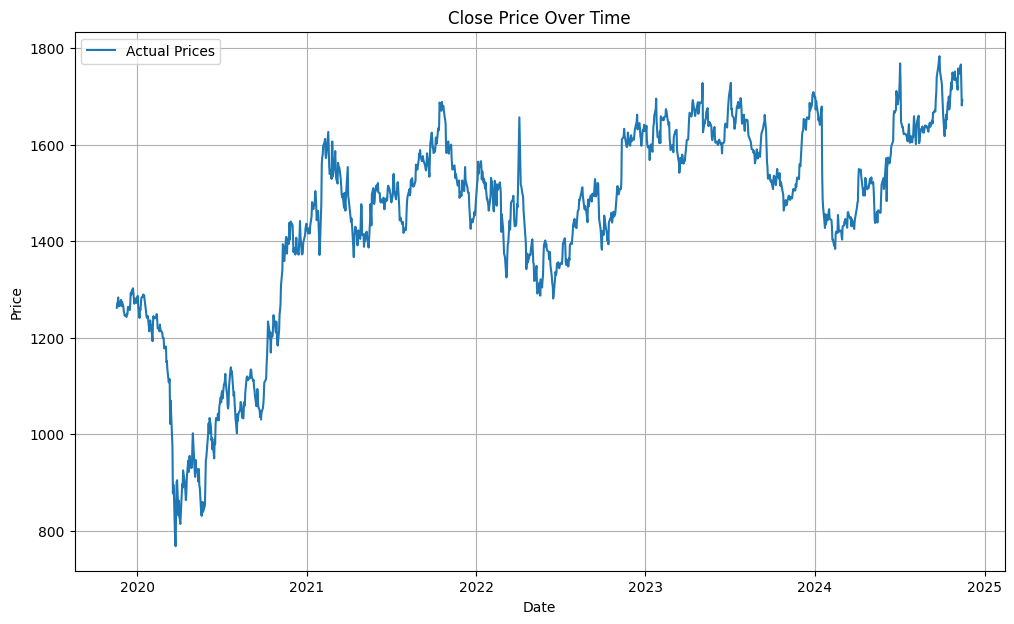

In [31]:
# Customize the plot
plt.figure(figsize=(12, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices')

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price Over Time")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

In [32]:
def fetch_tweets(query, cursor=None):
    url = "https://twitter-api45.p.rapidapi.com/search.php"
    headers = {
        "x-rapidapi-key": "4ec154cc17mshfb1a17a88a74772p159e36jsn6467a42c7d46",
        "x-rapidapi-host": "twitter-api45.p.rapidapi.com"
    }
    querystring = {"query": query, "search_type": "Latest"}
    if cursor:
        querystring["cursor"] = cursor

    response = requests.get(url, headers=headers, params=querystring)
    if response.status_code == 200:
        data = response.json()
        return data.get("timeline", []), data.get("next_cursor")
    else:
        print(f"Error: {response.status_code}")
        return [], None

def analyze_tweet_sentiment(tweets):
    analyzer = SentimentIntensityAnalyzer()
    global_polarity = 0
    positive_count = negative_count = 0

    for tweet in tweets:
        text = tweet.get("text", "")
        sentiment_score = analyzer.polarity_scores(text)
        global_polarity += sentiment_score["compound"]

        if sentiment_score["compound"] >= 0.05:
            positive_count += 1
        elif sentiment_score["compound"] <= -0.05:
            negative_count += 1

    return global_polarity, positive_count, negative_count

def get_recommendation(positive_count, neutral_count, negative_count):
    if positive_count > negative_count and positive_count > neutral_count:
        return "Buy"
    elif negative_count > positive_count and negative_count > neutral_count:
        return "Sell"
    else:
        return "Hold"

def retrieve_tweets_polarity(symbol):
    # Load stock ticker mapping
    stock_ticker_map = pd.read_csv('Yahoo-Finance-Ticker-Symbols.csv')
    symbol_name = stock_ticker_map[stock_ticker_map['Ticker'] == symbol]['Name'].values[0]

    print(f"Fetching tweets for {symbol_name}...")
    all_tweets = []
    cursor = None
    api_call_count = 0

    # Fetch tweets with a limit of 5 API calls
    while api_call_count < 5:
        tweets, cursor = fetch_tweets(f"{symbol_name}", cursor)

        if not tweets:
            break
        all_tweets.extend(tweets)
        api_call_count += 1
        if not cursor:
            break

    if not all_tweets:
        print("No tweets found for this symbol.")
        return

    # Analyze the sentiment of the fetched tweets
    global_polarity, positive_count, negative_count = analyze_tweet_sentiment(all_tweets)
    total_tweets = len(all_tweets)
    neutral_count = total_tweets - positive_count - negative_count

    # Calculate percentages
    positive_percentage = (positive_count / total_tweets) * 100
    neutral_percentage = (neutral_count / total_tweets) * 100
    negative_percentage = (negative_count / total_tweets) * 100

    print(f"Global Polarity: {global_polarity}")
    print(f"Positive Tweets: {positive_count} ({positive_percentage:.2f}%)")
    print(f"Neutral Tweets: {neutral_count} ({neutral_percentage:.2f}%)")
    print(f"Negative Tweets: {negative_count} ({negative_percentage:.2f}%)")
    print(f"Total Tweets: {total_tweets}")

    # Determine recommendation based on sentiment
    recommendation = get_recommendation(positive_count, neutral_count, negative_count)
    print(f"Recommendation: {recommendation}")


In [33]:
def LSTM_ALGO(df, forecast_days=7):
    scaler = MinMaxScaler()
    df['Date'] = pd.to_datetime(df['Date'])
    data = df[['Close']].values
    train_data = data[:int(0.8 * len(data))]
    test_data = data[int(0.8 * len(data)):]

    scaled_data = scaler.fit_transform(data)
    train_scaled = scaled_data[:len(train_data)]
    test_scaled = scaled_data[len(train_data):]

    X_train, y_train = [], []
    for i in range(7, len(train_scaled)):
        X_train.append(train_scaled[i - 7:i, 0])
        y_train.append(train_scaled[i, 0])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

    # Predict on the test set
    X_test, y_test = [], []
    for i in range(7, len(test_scaled)):
        X_test.append(test_scaled[i - 7:i, 0])
        y_test.append(test_scaled[i, 0])

    X_test = np.array(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)  # Rescale predictions
    y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))  # Rescale y_test

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)

    # Predict future prices
    future_prices = []
    last_sequence = scaled_data[-7:]  # Last 7 days from the scaled data

    for _ in range(forecast_days):
        prediction = model.predict(last_sequence[np.newaxis, :, :])
        future_prices.append(prediction[0, 0])

        # Update the sequence with the predicted value
        last_sequence = np.append(last_sequence[1:], prediction).reshape(-1, 1)

    # Rescale the predictions back to the original scale
    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1)).flatten()

    # Generate future business dates (working days)
    last_date = df['Date'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq="B")

    # Plot the results of Predicted
    plt.figure(figsize=(14, 7))
    plt.plot(future_dates, future_prices, label='Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Predicted Stock Price Prediction using LSTM')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the results of Actual + Predicted
    plt.figure(figsize=(14, 7))

    # Get the dates corresponding to the test set predictions
    test_dates = df['Date'][int(0.8 * len(df)):len(df) - forecast_days]  # Adjusted for forecast_days

    plt.plot(df['Date'], df['Close'], label='Actual Prices')

    # Plot predictions against the corresponding test dates
    plt.plot(test_dates, predictions.flatten(), label='Predicted Prices on test')  # Flatten predictions to 1D

    plt.plot(future_dates, future_prices, label='Predicted Prices', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Price Prediction using LSTM')
    plt.legend()
    plt.grid()
    plt.show()

    # Output future predictions
    for date, price in zip(future_dates, future_prices):
        print(f"{date.date()}: {price:.2f}")

    # Add last predicted close price to output
    last_date_in_dataset = df['Date'].iloc[-1]
    last_predicted_price = predictions[-1, 0]  # Last prediction from the test set
    last_predicted_price = scaler.inverse_transform([[last_predicted_price]])[0, 0]

    print(f"Last Predicted Close Price on {last_date_in_dataset.date()}: {last_predicted_price:.2f}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 7, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 7, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2417
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0161
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0105
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0079
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0072
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0061
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0058
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0060
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0064
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0055
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0056
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0058
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0057
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - l

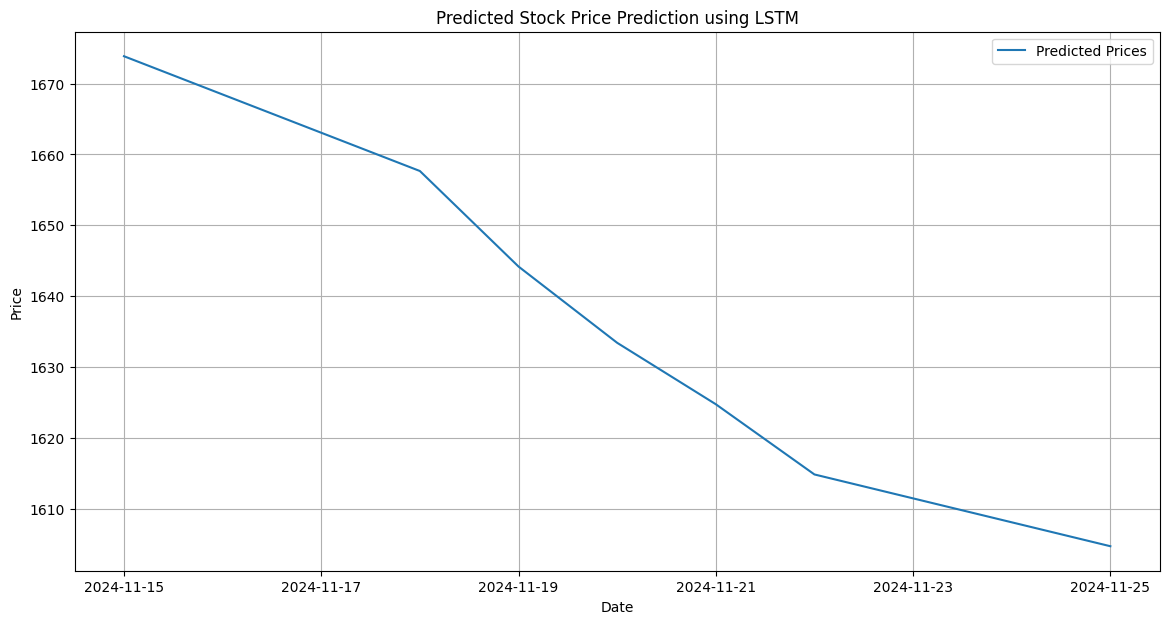

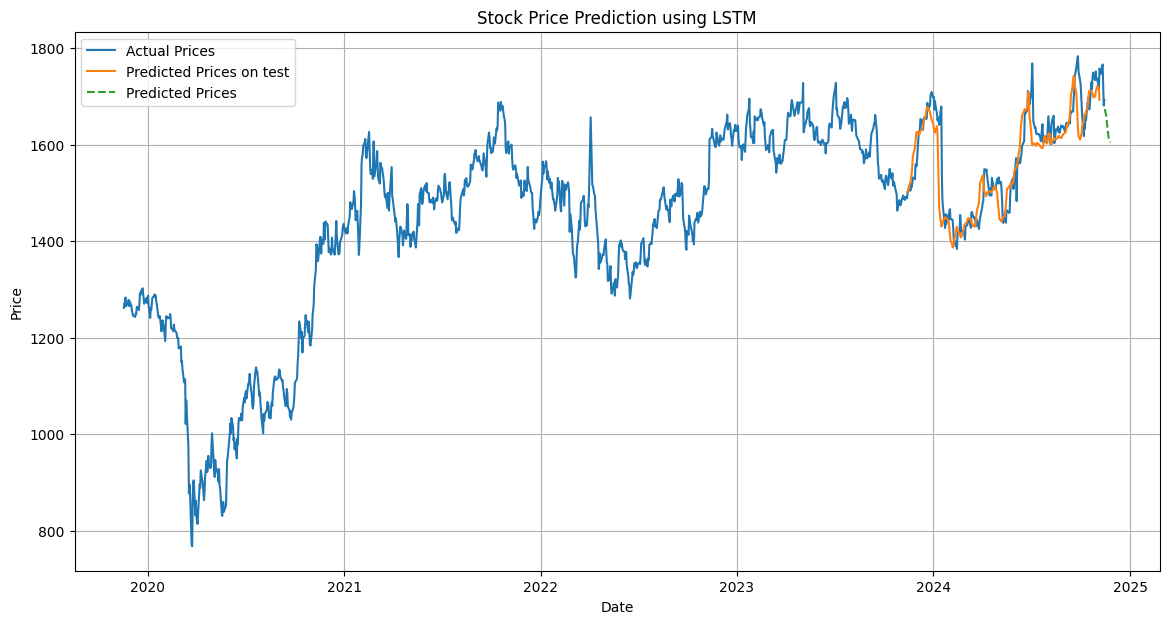

2024-11-15: 1673.88
2024-11-18: 1657.67
2024-11-19: 1644.18
2024-11-20: 1633.41
2024-11-21: 1624.73
2024-11-22: 1614.82
2024-11-25: 1604.68
Last Predicted Close Price on 2024-11-14: 1720403.33
RMSE: 36.04993605198837
MAE: 29.05459582063667


In [34]:
LSTM_ALGO(df)

In [35]:
retrieve_tweets_polarity(symbol)

Fetching tweets for HDFC Bank Limited...
Global Polarity: 11.616699999999998
Positive Tweets: 37 (64.91%)
Neutral Tweets: 7 (12.28%)
Negative Tweets: 13 (22.81%)
Total Tweets: 57
Recommendation: Buy
